<a href="https://colab.research.google.com/github/Itsuki-Hamano123/auto_ml/blob/master/tool_comparison/adult_census/kerasTuner_one_hot_DNN_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

カテゴリ変数はone-hotエンコードし、標準化済みの数値型の特徴量と単純に結合する

In [1]:
%pip install -q keras-tuner
%pip show tensorflow scikit-learn

     |████████████████████████████████| 71kB 4.1MB/s 
Name: tensorflow
Version: 2.3.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, grpcio, google-pasta, wheel, astunparse, six, keras-preprocessing, gast, tensorboard, protobuf, absl-py, tensorflow-estimator, wrapt, scipy, termcolor, h5py, opt-einsum
Required-by: fancyimpute
---
Name: scikit-learn
Version: 0.22.2.post1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: joblib, numpy, scipy
Required-by: yellowbrick, umap-learn, textgenrnn, sklearn, sklearn-pandas, mlxtend, lucid, lightgbm, librosa, keras-tuner, imbalanced-learn, fancyimpute


[国税調査データセット:https://www.openml.org/d/1590](https://www.openml.org/d/1590)

In [2]:
import datetime, IPython, os 

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from kerastuner import HyperModel, Hyperband
from tensorflow.keras import Model, Input, layers, optimizers, callbacks
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.utils import plot_model

# データ読み込み

In [6]:
%%time
DATA_ID = '1590' #@param{type:'string'}

# データセットをフェッチ
result = fetch_openml(data_id=DATA_ID,
                    as_frame=True)

X = result.data
y = result.target
x_cols = result.feature_names
y_col = result.target_names

display(x_cols)
display(X.head())
display(y_col)
display(y.head())


def proc_y(y):
    '''ラベルの加工'''

    def _one_hot_encode(y):
        '''ワンホットエンコードしたnumpy.ndarrayを返す'''
        return pd.get_dummies(y)

    proc_y = _one_hot_encode(y=y)
    return proc_y


def proc_X(X, one_hot_encode_cols):
    '''特徴量の加工'''
    def _one_hot_encode(X, X_cols, drop_first=True):
        '''ワンホットエンコードしたDataframeを返す'''
        return pd.get_dummies(X, columns=X_cols,
                              drop_first=drop_first)

    proc_X = _one_hot_encode(X=X, X_cols=one_hot_encode_cols)
    return proc_X


one_hot_encode_cols = ['workclass', 'education', 'marital-status', 'occupation',
                       'relationship', 'race', 'sex', 'native-country']
numericla_cols =  set(X.columns) ^ set(one_hot_encode_cols)
X=proc_X(X=X, one_hot_encode_cols=one_hot_encode_cols)
y=proc_y(y=y)

display(X.head())
display(y.head())


# 数値型の特徴量とワンホットエンコード型の特徴量の分離
# INFO : 数値型とワンホットエンコード型の特徴量が混在していると標準化がうまくできない
def separate_numerical_X_and_one_hot_X(X, numericla_cols):
    '''数値型の特徴量とワンホットエンコード型の特徴量を分離する
    
    Parameters
    -----
    X : pandas.Dataframe
    numericla_cols : list of string
      数値型のデータが格納されている列名
    
    Returns
    -----
    numerical_X : pandas.Dataframe
    one_hot_X : pandas.Dataframe
    '''
    cols = X.columns
    one_hot_cols = set(cols) ^ set(numericla_cols)
    
    numerical_X = X.loc[:,numericla_cols]
    one_hot_X = X.loc[:,one_hot_cols]
    return numerical_X, one_hot_X


numerical_X, one_hot_X = separate_numerical_X_and_one_hot_X(X, numericla_cols)
display(numerical_X.head())
display(one_hot_X.head())


SEED = 7 #@param{type:'number'}
SPLIT = 0.2 #@param{type:'number'}

train_num_X, test_num_X, train_one_hot_X, test_one_hot_X, train_y, test_y = train_test_split(numerical_X.values, one_hot_X.values, y,
                                                                                              test_size=SPLIT,
                                                                                              random_state=SEED,
                                                                                              shuffle=True)
train_num_X, val_num_X, train_one_hot_X, val_one_hot_X, train_y, val_y = train_test_split(train_num_X, train_one_hot_X, train_y,
                                                                                          test_size=SPLIT,
                                                                                          random_state=SEED,
                                                                                          shuffle=True)
def create_dictionary(values, keys):
    '''辞書型のオブジェクト作成'''
    obj = {}
    for val, key in zip(values, keys):
        obj[key] = val
    return obj

numerical_key = 'numerical_X'
one_hot_key = 'one_hot_X'
keys = [numerical_key, one_hot_key]
train_X = create_dictionary(values=[train_num_X, train_one_hot_X], keys=keys)
val_X = create_dictionary(values=[val_num_X, val_one_hot_X], keys=keys)
test_X = create_dictionary(values=[test_num_X, test_one_hot_X], keys=keys)

display('train_X numerical shape:{}'.format(train_X[numerical_key].shape))
display('val_X numerical shape:{}'.format(val_X[numerical_key].shape))
display('test_X numerical shape:{}'.format(test_X[numerical_key].shape))

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country']

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States


['class']

0    <=50K
1    <=50K
2     >50K
3     >50K
4    <=50K
Name: class, dtype: category
Categories (2, object): ['>50K', '<=50K']

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Self-emp-not-inc,workclass_Self-emp-inc,workclass_Federal-gov,workclass_Local-gov,workclass_State-gov,workclass_Without-pay,workclass_Never-worked,education_Some-college,education_11th,education_HS-grad,education_Prof-school,education_Assoc-acdm,education_Assoc-voc,education_9th,education_7th-8th,education_12th,education_Masters,education_1st-4th,education_10th,education_Doctorate,education_5th-6th,education_Preschool,marital-status_Divorced,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,marital-status_Married-spouse-absent,marital-status_Married-AF-spouse,occupation_Craft-repair,occupation_Other-service,occupation_Sales,occupation_Exec-managerial,occupation_Prof-specialty,occupation_Handlers-cleaners,...,native-country_Cambodia,native-country_England,native-country_Puerto-Rico,native-country_Canada,native-country_Germany,native-country_Outlying-US(Guam-USVI-etc),native-country_India,native-country_Japan,native-country_Greece,native-country_South,native-country_China,native-country_Cuba,native-country_Iran,native-country_Honduras,native-country_Philippines,native-country_Italy,native-country_Poland,native-country_Jamaica,native-country_Vietnam,native-country_Mexico,native-country_Portugal,native-country_Ireland,native-country_France,native-country_Dominican-Republic,native-country_Laos,native-country_Ecuador,native-country_Taiwan,native-country_Haiti,native-country_Columbia,native-country_Hungary,native-country_Guatemala,native-country_Nicaragua,native-country_Scotland,native-country_Thailand,native-country_Yugoslavia,native-country_El-Salvador,native-country_Trinadad&Tobago,native-country_Peru,native-country_Hong,native-country_Holand-Netherlands
0,25.0,226802.0,7.0,0.0,0.0,40.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,38.0,89814.0,9.0,0.0,0.0,50.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,28.0,336951.0,12.0,0.0,0.0,40.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,44.0,160323.0,10.0,7688.0,0.0,40.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18.0,103497.0,10.0,0.0,0.0,30.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,>50K,<=50K
0,0,1
1,0,1
2,1,0
3,1,0
4,0,1


,fnlwgt,capital-gain,age,education-num,capital-loss,hours-per-week
0,226802.0,0.0,25.0,7.0,0.0,40.0
1,89814.0,0.0,38.0,9.0,0.0,50.0
2,336951.0,0.0,28.0,12.0,0.0,40.0
3,160323.0,7688.0,44.0,10.0,0.0,40.0
4,103497.0,0.0,18.0,10.0,0.0,30.0


,occupation_Priv-house-serv,education_11th,native-country_Mexico,race_Amer-Indian-Eskimo,native-country_Ecuador,relationship_Husband,race_Black,native-country_Laos,education_HS-grad,occupation_Sales,native-country_Peru,relationship_Not-in-family,occupation_Adm-clerical,occupation_Machine-op-inspct,native-country_Jamaica,workclass_Local-gov,native-country_England,education_Masters,native-country_China,marital-status_Married-spouse-absent,native-country_South,native-country_El-Salvador,occupation_Other-service,native-country_France,education_7th-8th,education_5th-6th,native-country_Vietnam,native-country_Taiwan,native-country_Guatemala,marital-status_Divorced,native-country_Cambodia,marital-status_Married-AF-spouse,workclass_Federal-gov,native-country_Yugoslavia,workclass_Self-emp-inc,native-country_Cuba,native-country_Scotland,native-country_Columbia,education_1st-4th,native-country_Canada,...,native-country_Japan,native-country_Trinadad&Tobago,occupation_Exec-managerial,native-country_Iran,education_Prof-school,race_Asian-Pac-Islander,education_9th,native-country_Italy,native-country_Ireland,native-country_Haiti,education_10th,education_Assoc-acdm,native-country_Honduras,native-country_Nicaragua,occupation_Protective-serv,occupation_Prof-specialty,education_Preschool,native-country_Portugal,sex_Male,native-country_Greece,occupation_Armed-Forces,marital-status_Separated,education_12th,marital-status_Never-married,relationship_Own-child,occupation_Handlers-cleaners,workclass_State-gov,occupation_Farming-fishing,native-country_Germany,native-country_Thailand,race_Other,occupation_Craft-repair,relationship_Unmarried,native-country_Puerto-Rico,native-country_Hong,native-country_Holand-Netherlands,marital-status_Widowed,workclass_Without-pay,native-country_Philippines,education_Some-college
0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


'train_X numerical shape:(31258, 6)'

'val_X numerical shape:(7815, 6)'

'test_X numerical shape:(9769, 6)'

CPU times: user 1.43 s, sys: 54.8 ms, total: 1.49 s
Wall time: 17.8 s


# モデル構築

In [7]:
%%time
class CensusHyperModel(HyperModel):

      def __init__(self, train_numerical_X, one_hot_dim, num_class, dropout_seed=None):
          '''
          Parameters
          -----
          train_numerical_X : numpy.ndarray
            標準化レイヤーに適合させる数値型の特徴量
          one_hot_dim : int or tuple
            ワンホットエンコードしている次元数
          num_class : int
            分類するクラス数
          dropout_seed : float (default : None)
          '''
          self.train_numerical_X = train_numerical_X
          self.one_hot_dim = one_hot_dim
          self.num_class = num_class
          self.dropout_seed = dropout_seed
          self.norm_layer = self._setup_norm_layer(adapt_X=train_numerical_X)


      def _setup_norm_layer(self, adapt_X):
          '''標準化レイヤーのセットアップ'''
          norm_layer = Normalization()
          norm_layer.adapt(adapt_X)
          return norm_layer


      def build(self, hp):
          '''モデルの構造定義'''

          # 数値データ用の入力層
          input_shape = self.train_numerical_X.shape[1]
          numerical_input = layers.Input(shape=input_shape,
                                        name='numerical_X')
          numerical_features = self.norm_layer(numerical_input)

          # one-hot-vector用の入力レイヤー
          one_hot_input = layers.Input(shape=self.one_hot_dim,
                                      name='one_hot_X')
          
          # 複数の入力層の結合を行うレイヤー
          x = layers.concatenate(inputs=[numerical_input, one_hot_input])

          # データ解析レイヤー
          for i in range(hp.Int('num_layers', min_value=2, max_value=7, step=1)):
              units = hp.Int('units_'+str(i), min_value=32, max_value=512, step=32)
              x = layers.Dense(units=units, activation='relu')(x)
              x = layers.Dropout(rate=0.3, seed=self.dropout_seed)(x)

          # 出力レイヤー
          output = layers.Dense(units=self.num_class, activation='softmax')(x)

          model = Model(inputs=[numerical_input, one_hot_input],
                        outputs=output)

          model.compile(optimizer=optimizers.Adam(hp.Choice('learning_rate', [1e-1, 1e-3, 1e-4])),
                        loss='categorical_crossentropy', 
                        metrics=['accuracy'])
          return model


one_hot_dim = train_X[one_hot_key].shape[1]
num_class = train_y.shape[1]

hyper_model = CensusHyperModel(train_numerical_X=train_X[numerical_key],
                                one_hot_dim=one_hot_dim,
                                num_class=num_class,
                                dropout_seed=SEED)
display(hyper_model)

CPU times: user 569 ms, sys: 389 ms, total: 958 ms
Wall time: 5.35 s


In [8]:
# Hyperbandアルゴリズム自体の試行回数(default:1)
HYPERBAND_ITERATIONS =  1#@param{type:'number'}
# バケット内のモデルを選択する際の割合(default:3)
FACTOR = 3 #@param{type:'number'}
# モデル1つあたりの最大Epoch数
MAX_EPOCHS = 100 #@param{type:'number'}

BATCH_SIZE = 1024 #@param{type:'number'}

tuner = Hyperband(hypermodel=hyper_model,
                  objective='val_accuracy',
                  hyperband_iterations=HYPERBAND_ITERATIONS,
                  factor=FACTOR,
                  max_epochs=MAX_EPOCHS,
                  seed=SEED
                  )
display(tuner)

# 早期停止コールバックの定義
es = callbacks.EarlyStopping(monitor='val_loss',
                             patience=2)

class ClearTrainingOutput(callbacks.Callback):
    '''Ipythonログをクリアするコールバックのクラス定義'''
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [9]:
%%time
tuner.search(x=train_X, y=train_y,
             batch_size=BATCH_SIZE,
             validation_data=(val_X, val_y),
             callbacks=[es, ClearTrainingOutput()],
             verbose=1)

Trial 254 Complete [00h 00m 02s]
val_accuracy: 0.7568777799606323

Best val_accuracy So Far: 0.7964171171188354
Total elapsed time: 00h 07m 17s
INFO:tensorflow:Oracle triggered exit
CPU times: user 6min 59s, sys: 32.9 s, total: 7min 32s
Wall time: 7min 17s


# ベストなモデルの可視化

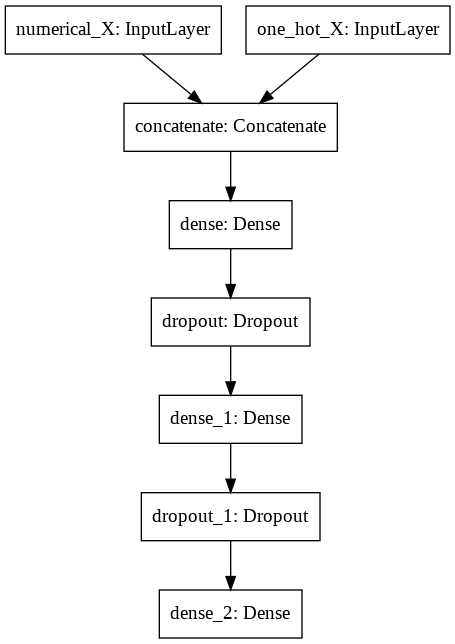

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
numerical_X (InputLayer)        [(None, 6)]          0                                            
__________________________________________________________________________________________________
one_hot_X (InputLayer)          [(None, 91)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 97)           0           numerical_X[0][0]                
                                                                 one_hot_X[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           3136        concatenate[0][0]     

None

CPU times: user 436 ms, sys: 37 ms, total: 473 ms
Wall time: 717 ms


In [10]:
%%time
def take_best_model(tuner):
    '''ベストなモデルの取り出し'''
    best_model = tuner.get_best_models(num_models=1)[0]
    return best_model


def display_model(model):
    '''DNNの構造を表示'''
    display(plot_model(model))
    display(model.summary())


classifier = take_best_model(tuner)
display_model(model=classifier)

# モデルの評価

## Kerasの組み込み評価関数

In [11]:
%%time
score = classifier.evaluate(x=test_X, y=test_y, batch_size=BATCH_SIZE)
display('loss : {}, accuracy : {}'.format(score[0], score[1]))

10/10 [==============================] - 0s 2ms/step - loss: 1.1049 - accuracy: 0.7934


'loss : 1.1048539876937866, accuracy : 0.7934281826019287'

CPU times: user 222 ms, sys: 14.9 ms, total: 237 ms
Wall time: 236 ms


## sklearnの評価関数

In [12]:
%%time
def predict_classes(model, x):
    '''ラスラベルの予測を取得'''
    return np.argmax(model.predict(x), axis=-1)


# 予測結果の取得
train_y_pred = predict_classes(classifier, train_X)
val_y_pred = predict_classes(classifier, val_X)
test_y_pred = predict_classes(classifier, test_X)


def encode_label_classes(one_hot_encode_y):
    '''ワンホットエンコードをラベルエンコードに変換'''
    return np.argmax(one_hot_encode_y.values, axis=-1)

train_report = classification_report(y_true=encode_label_classes(train_y),
                                     y_pred=train_y_pred)
val_report = classification_report(y_true=encode_label_classes(val_y),
                                   y_pred=val_y_pred)
test_report = classification_report(y_true=encode_label_classes(test_y),
                                    y_pred=test_y_pred)


print(train_report)
print('----- -----')
print(val_report)
print('----- -----')
print(test_report)

              precision    recall  f1-score   support

           0       0.75      0.24      0.36      7477
           1       0.80      0.98      0.88     23781

    accuracy                           0.80     31258
   macro avg       0.78      0.61      0.62     31258
weighted avg       0.79      0.80      0.76     31258

----- -----
              precision    recall  f1-score   support

           0       0.77      0.23      0.36      1900
           1       0.80      0.98      0.88      5915

    accuracy                           0.80      7815
   macro avg       0.78      0.61      0.62      7815
weighted avg       0.79      0.80      0.75      7815

----- -----
              precision    recall  f1-score   support

           0       0.71      0.21      0.33      2310
           1       0.80      0.97      0.88      7459

    accuracy                           0.79      9769
   macro avg       0.76      0.59      0.60      9769
weighted avg       0.78      0.79      0.75      9